In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
!curl -O https://lazyprogrammer.me/course_files/timeseries/us_macro_quarterly.xlsx

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  2 76805    2  1971    0     0   1023      0  0:01:15  0:00:01  0:01:14  1024
100 76805  100 76805    0     0  39371      0  0:00:01  0:00:01 --:--:-- 39427


In [3]:
df = pd.read_excel('us_macro_quarterly.xlsx')

C:\Users\asus\anaconda31\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [4]:
df.head()

,Unnamed: 0,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
0,1957:01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1,1957:02,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
2,1957:03,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333
3,1957:04,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000
4,1958:01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667


We Take two values GDPC96 and 

In [5]:
def parse_date(data):
    # quarter is in {01,02,03,04}
    year,quarter=data.split(':')
    month=(int(quarter)-1)*3+1
    s=f"{year}-{month}"
    return datetime.strptime(s, "%Y-%m")

In [6]:
df['Date']=df['Unnamed: 0'].apply(parse_date)

In [7]:
df.head()

,Unnamed: 0,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL,Date
0,1957:01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667,1957-01-01
1,1957:02,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333,1957-04-01
2,1957:03,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333,1957-07-01
3,1957:04,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000,1957-10-01
4,1958:01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667,1958-01-01


In [8]:
df.set_index(df['Date'],inplace=True)
df.drop(['Date','Unnamed: 0'],axis=1,inplace=True)

In [9]:
df.index.freq='QS'

In [10]:
df.head()

,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
Date,,,,,,,,,
1957-01-01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1957-04-01,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
1957-07-01,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333
1957-10-01,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000
1958-01-01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667


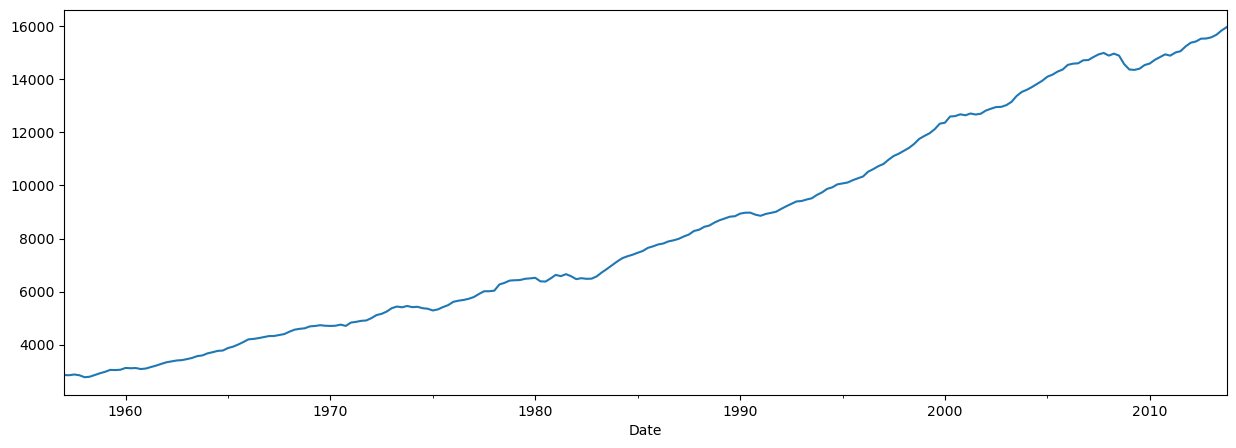

In [11]:
# GDP
df['GDPC96'].plot(figsize=(15,5));

In [12]:
df['GDPGrowth']=np.log(df['GDPC96']).diff()

In [13]:
df['Tspread']=df['GS10']-df['TB3MS']

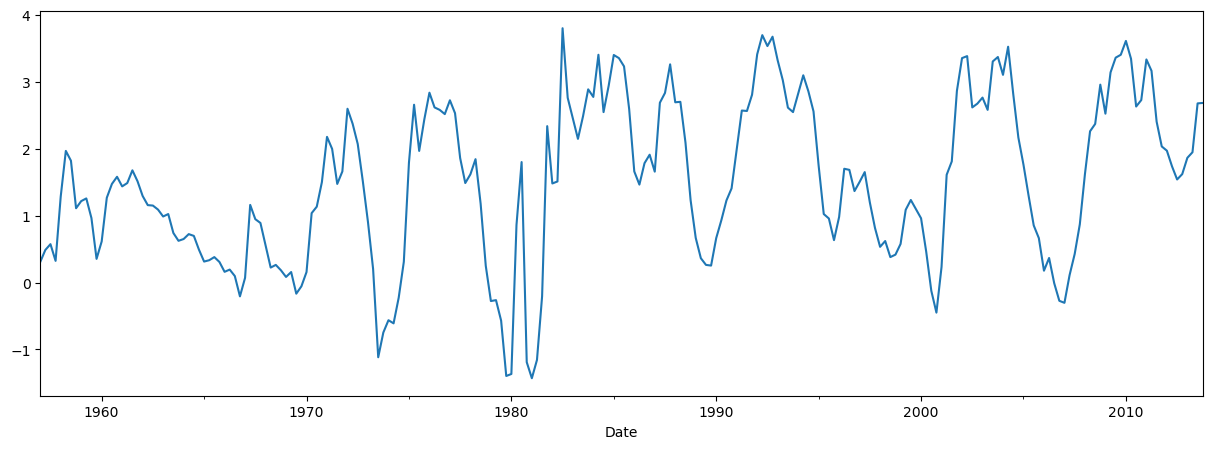

In [14]:
df['Tspread'].plot(figsize=(15,5));

In [15]:
cols=['GDPGrowth','Tspread']

In [16]:
df1=df.iloc[1:][cols].copy()

In [17]:
Ntest =12
train=df1.iloc[:-Ntest].copy()
test=df1.iloc[-Ntest:].copy()

In [18]:
train_idx=df1.index<=train.index[-1]
test_idx=df1.index>train.index[-1]

In [19]:
# just overwrite originals,unless you want to preserve them
scaler=StandardScaler()
train[cols]=scaler.fit_transform(train)
test[cols]=scaler.transform(test)

In [20]:
df1.loc[train_idx,:]=train
df1.loc[test_idx,:]=test

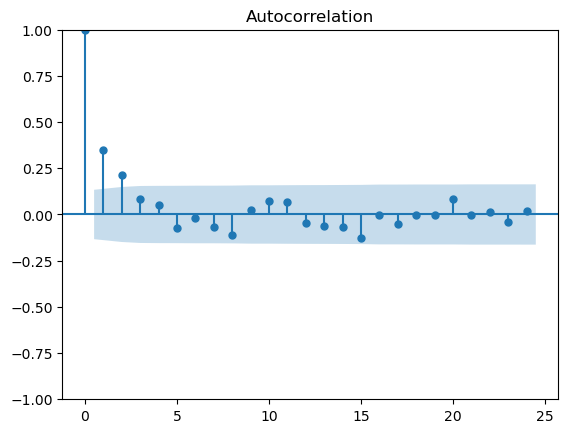

In [21]:
plot_acf(train['GDPGrowth']);

Based on GDP growth alone, the acf suggest small q value, note, however, that these are not exactly what you need, in order to determine p and q, since they do not consider cross terms. So these are used as rough guides to get some idea

In practice, easiest way to do a model selection is just to do a grid search and pick the best value based on the criteria you care about.


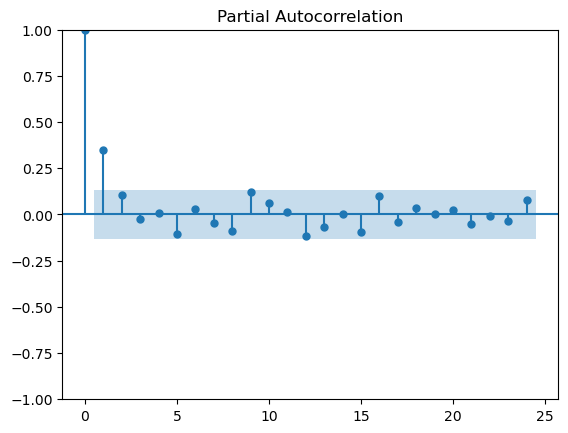

In [22]:
plot_pacf(train['GDPGrowth']);

PACF seem to suggest a small p value as well.

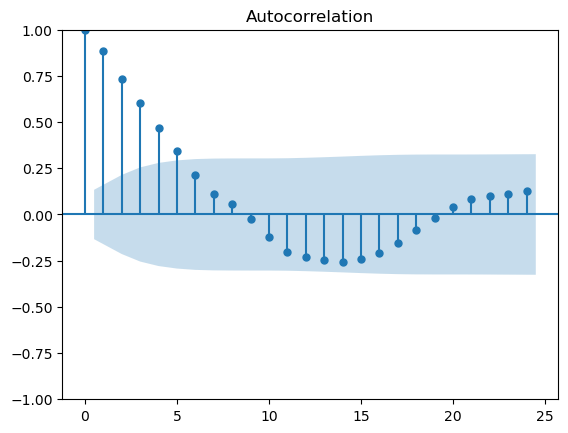

In [23]:
plot_acf(train['Tspread']);

ACF suggest that the signal has a cyclical pattern

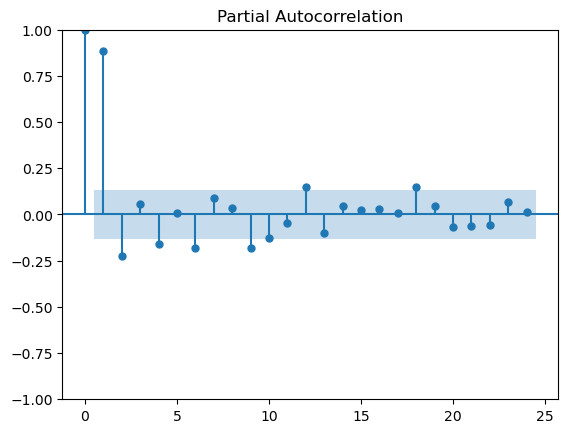

In [24]:
plot_pacf(train['Tspread']);

Quite a few lags are signifcant upto a high order

In [25]:
adfuller(train['GDPGrowth'])

(-7.446639654625577,
 5.8148965809140144e-11,
 1,
 213,
 {'1%': -3.461429147102264,
  '5%': -2.875206950587861,
  '10%': -2.5740544497344002},
 512.854231063742)

In [27]:
adfuller(train['Tspread'])

(-4.001020795475583,
 0.0014051754907493511,
 12,
 202,
 {'1%': -3.4631437906252636,
  '5%': -2.8759570379821047,
  '10%': -2.574454682874228},
 246.36949884218734)

In [29]:
p=18
q=1

In [30]:
t0=datetime.now()
model=VARMAX(train,order=(p,q))
res=model.fit(maxiter=100)
print("Duration:",datetime.now()-t0)

C:\Users\asus\anaconda31\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\asus\anaconda31\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duration: 0:01:49.447012


In [31]:
fcast=res.get_forecast(Ntest)

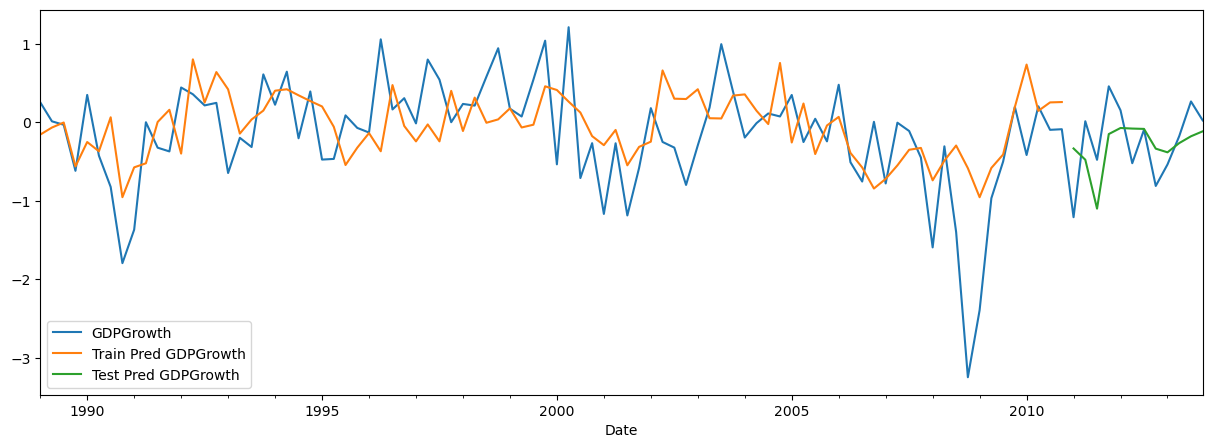

In [33]:
df1.loc[train_idx,'Train Pred GDPGrowth']=\
res.fittedvalues['GDPGrowth']

df1.loc[test_idx,'Test Pred GDPGrowth']=\
fcast.predicted_mean['GDPGrowth']

plot_cols=['GDPGrowth','Train Pred GDPGrowth','Test Pred GDPGrowth']
df1.iloc[-100:][plot_cols].plot(figsize=(15,5));

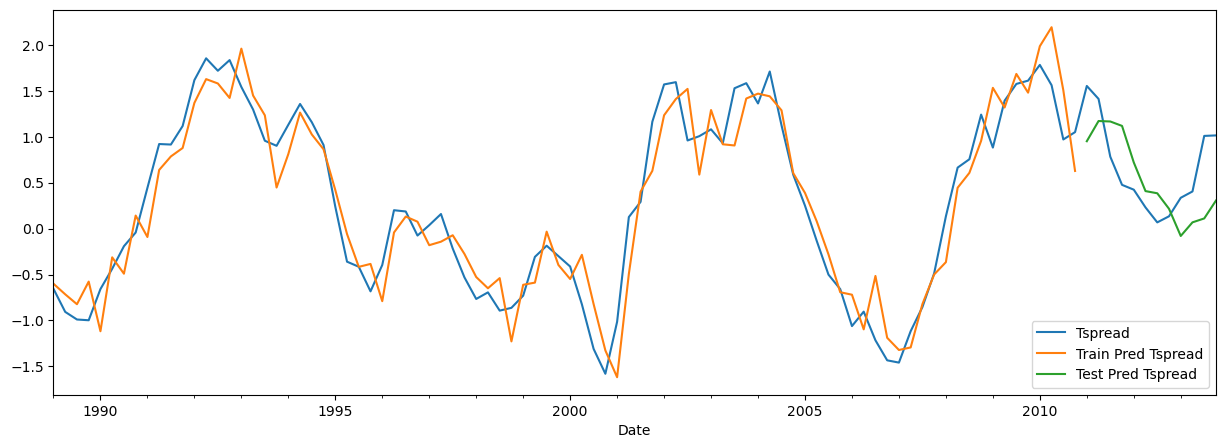

In [34]:
df1.loc[train_idx,'Train Pred Tspread']=\
res.fittedvalues['Tspread']

df1.loc[test_idx,'Test Pred Tspread']=\
fcast.predicted_mean['Tspread']

plot_cols=['Tspread','Train Pred Tspread','Test Pred Tspread']
df1.iloc[-100:][plot_cols].plot(figsize=(15,5));

In [37]:
for col in cols:
    y_true=df1.loc[train_idx,col]
    y_pred=res.fittedvalues[col]
    print("Train R^2:",r2_score(y_true,y_pred))
    
    y_true=df1.loc[test_idx,col]
    y_pred=fcast.predicted_mean[col]
    print("Test R^2:",r2_score(y_true,y_pred))

Train R^2: 0.2764660894969676
Test R^2: 0.024392896119498686
Train R^2: 0.8736742059110935
Test R^2: -0.038944425371254754


## VAR

In [38]:
model=VAR(train)

In [39]:
lag_order_results=model.select_order(maxlags=20)
lag_order_results.selected_orders

{'aic': 10, 'bic': 1, 'hqic': 2, 'fpe': 10}

In [40]:
results=model.fit(maxlags=20,ic='aic')

In [41]:
lag_order=results.k_ar

In [42]:
prior=train.iloc[-lag_order:][cols].to_numpy() # why need this ?
fcast=results.forecast(prior,Ntest)

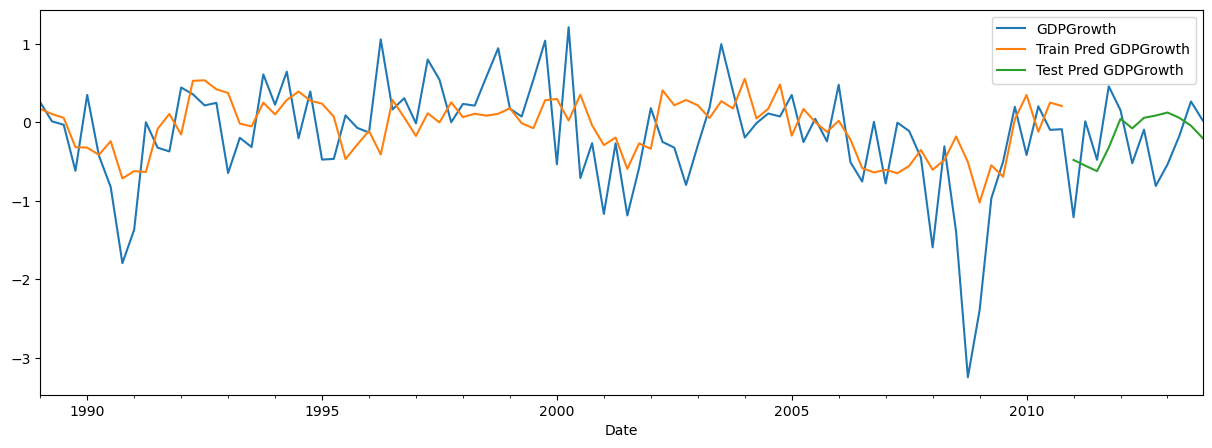

In [44]:
df1.loc[train_idx,'Train Pred GDPGrowth']=\
results.fittedvalues['GDPGrowth']
df1.loc[test_idx,'Test Pred GDPGrowth']=\
fcast[:,0]

plot_cols=['GDPGrowth','Train Pred GDPGrowth','Test Pred GDPGrowth']
df1.iloc[-100:][plot_cols].plot(figsize=(15,5));

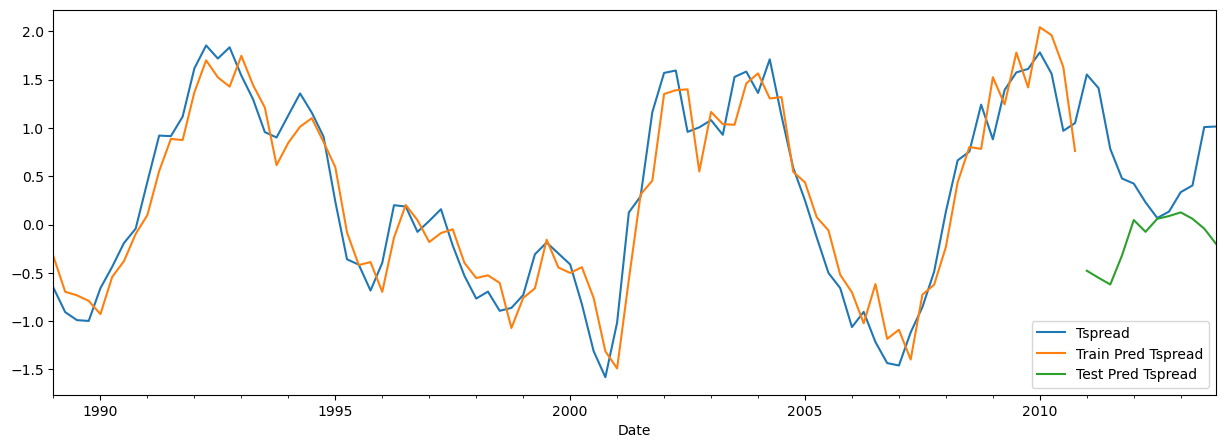

In [45]:
df1.loc[train_idx,'Train Pred Tspread']=\
results.fittedvalues['Tspread']
df1.loc[test_idx,'Test Pred Tspread']=\
fcast[:,0]

plot_cols=['Tspread','Train Pred Tspread','Test Pred Tspread']
df1.iloc[-100:][plot_cols].plot(figsize=(15,5));

In [46]:
y_pred=df1.loc[train_idx,'Train Pred GDPGrowth']
y_true=df1.loc[train_idx,'GDPGrowth']
y_true=y_true.iloc[lag_order:]
y_pred=y_pred.iloc[lag_order:]
print('GDPGrowth Train R^2:',r2_score(y_true,y_pred))

y_pred=df1.loc[test_idx,'Test Pred GDPGrowth']
y_true=df1.loc[test_idx,'GDPGrowth']
print('GDPGrowth Test R^2:',r2_score(y_true,y_pred))

GDPGrowth Train R^2: 0.2569812409739455
GDPGrowth Test R^2: -0.23961760567261536


In [47]:
y_pred=df1.loc[train_idx,'Train Pred Tspread']
y_true=df1.loc[train_idx,'Tspread']
y_true=y_true.iloc[lag_order:]
y_pred=y_pred.iloc[lag_order:]
print('Tspread Train R^2:',r2_score(y_true,y_pred))

y_pred=df1.loc[test_idx,'Test Pred Tspread']
y_true=df1.loc[test_idx,'Tspread']
print('Tspread Test R^2:',r2_score(y_true,y_pred))

Tspread Train R^2: 0.8581031996649262
Tspread Test R^2: -4.026756650544339


## ARIMA Baseline

In [52]:
for col in cols:
    model=ARIMA(train[col],order=(p,0,q))
    res=model.fit()
    fcast=res.get_forecast(Ntest)
    y_train=df1.loc[train_idx,col]
    y_test=df1.loc[test_idx,col]
    print(f"{col} Train R^2:", r2_score(y_train, res.fittedvalues))
    print(f"{col} Test R^2:", r2_score(y_test, fcast.predicted_mean))

GDPGrowth Train R^2: 0.20569396110563187
GDPGrowth Test R^2: -0.8486487527776068
Tspread Train R^2: 0.8332486531726988
Tspread Test R^2: -2.9963834766867636
